In [1]:
!pip install gym==0.10.5

In [2]:
# Install gym-snake
!pip install -e ./Gym-Snake-master/

Obtaining file:///G:/Git/NUS_MComp/CS5446/cs5446_grp_proj/Gym-Snake-master
  Attempting uninstall: gym-snake
    Found existing installation: gym-snake 0.0.1
    Uninstalling gym-snake-0.0.1:
      Successfully uninstalled gym-snake-0.0.1
  Running setup.py develop for gym-snake


In [3]:
import numpy as np
import gym
import gym_snake
import os
import time
import inspect
import sys
from multiprocessing import Process
import torch
from torch import nn as nn
import torch.nn.functional as F

## Set Up Hyperparameters

In [4]:
env_name = 'snake-v0'
# exp_name = 'vpg'
render = False
animate = render
discount = 1.0
n_iter = 501
batch_size = 1000
ep_len = -1.
learning_rate = 1e-4
reward_to_go = False
dont_normalize_advantages = False
seed = 1
n_experiments = 1
max_path_length = 1e3
min_timesteps_per_batch = batch_size
gamma = discount
normalize_advantages = not(dont_normalize_advantages)

## Set Up Environment

In [5]:
#========================================================================================#
# Set Up Env
#========================================================================================#

# Make the gym environment
env = gym.make(env_name)

# Set random seeds
torch.manual_seed(seed)
np.random.seed(seed)
env.seed(seed)

# Maximum length for episodes
max_path_length = max_path_length or env.spec.max_episode_steps

# Is this env continuous, or self.discrete? In this assignment, we only consider discrete action space.
discrete = isinstance(env.action_space, gym.spaces.Discrete)

# Observation and action sizes
ob_dim = 15*15*3
ac_dim = env.action_space.n if discrete else env.action_space.shape[0]
print(ac_dim)

4


G:\Tool\Miniconda\envs\deeplearn_course\lib\site-packages\gym\envs\registration.py:14: PkgResourcesDeprecationWarning: Parameters to load are deprecated.  Call .resolve and .require separately.
  result = entry_point.load(False)


## Build a MLP model for policy learning.

In [6]:
class MLP(nn.Module):

    def __init__(self, input_size, num_actions):
        super(MLP, self).__init__()
        self.input_size = input_size
        self.pool1  = nn.MaxPool2d(10,10)
        self.dense1 = nn.Linear(input_size, 512)
        self.dense2 = nn.Linear(512, 512)
        self.dense3 = nn.Linear(512, num_actions)

    def forward(self, x):
        x = self.pool1(x)
        x = x.view(-1, self.input_size)
        x = F.tanh(self.dense1(x))
        x = F.tanh(self.dense2(x))
        out = F.softmax(self.dense3(x))
        return out


## Initialize Agent
    

In [7]:
policy_net = MLP(input_size=ob_dim, num_actions=ac_dim)
optimizer = torch.optim.Adam(policy_net.parameters(), lr=learning_rate)


## Data Sampling

In [8]:
def sample_action(policy_parameters):
    """
    Stochastically sampling from the policy distribution

    arguments:
        policy_parameters: logits of a categorical distribution over actions
                sy_logits_na: (batch_size, self.ac_dim)

    returns:
        sy_sampled_ac: (batch_size,)
    """

    #expects dim = (batch_size, 4)
    
    sy_sampled_ac = torch.multinomial(policy_parameters, 1)


    return sy_sampled_ac

In [9]:
sample_input = torch.Tensor([[0.4,0.6, 1.5], [1.0, 4.0, 3.0]])
sampled_acs = sample_action(sample_input)
print(sampled_acs)

tensor([[2],
        [2]])


In [10]:
print(ob_dim)
print(ac_dim)

675
4


In [11]:
def sample_trajectory(env):
    ob = env.reset()
    obs, acs, rewards = [], [], []
    steps = 0
    while True:

        ob_format = np.zeros((len(ob[0, 0]), len(ob), len(ob[0])), dtype=int)
        ob_format[0, :, :] = ob[:, :, 0]
        ob_format[1, :, :] = ob[:, :, 1]
        ob_format[2, :, :] = ob[:, :, 2]
        obs.append(ob_format)

        ob_format = torch.Tensor(ob_format)

        distribution = policy_net(torch.unsqueeze(ob_format, 0))
        ac = sample_action(distribution)

        ac = ac.numpy()[0]
        acs.append(ac)
        ob, rew, done, _ = env.step(ac)
        rewards.append(rew)
        steps += 1
        if done or steps > max_path_length:
            break
    path = {"observation" : np.array(obs, dtype=np.float32),
            "reward" : np.array(rewards, dtype=np.float32),
            "action" : np.array(acs, dtype=np.float32)}
    return path, steps


In [12]:
def sample_trajectories(itr, env):
    """Collect paths until we have enough timesteps, as determined by the
    length of all paths collected in this batch.
    """
    timesteps_this_batch = 0
    paths = []
    steps_list = []
    while True:
        path, steps= sample_trajectory(env)
        paths.append(path)
        steps_list.append(steps)
        timesteps_this_batch += len(path["reward"])
        if timesteps_this_batch > min_timesteps_per_batch:
            break
    return paths, timesteps_this_batch, steps_list

In [13]:
sample_trajectories(1, env)

G:\Tool\Miniconda\envs\deeplearn_course\lib\site-packages\torch\nn\functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ..\c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
G:\Tool\Miniconda\envs\deeplearn_course\lib\site-packages\torch\nn\functional.py:1794: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
G:\Tool\Miniconda\envs\deeplearn_course\lib\site-packages\ipykernel_launcher.py:16: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  app.launch_new_instance()


([{'observation': array([[[[  0.,   0.,   0., ...,   0.,   0.,   0.],
            [  0.,   0.,   0., ...,   0.,   0.,   0.],
            [  0.,   0.,   0., ...,   0.,   0.,   0.],
            ...,
            [  0.,   0.,   0., ...,   0.,   0.,   0.],
            [  0.,   0.,   0., ...,   0.,   0.,   0.],
            [  0.,   0.,   0., ...,   0.,   0.,   0.]],
   
           [[255., 255., 255., ..., 255., 255., 255.],
            [255., 255., 255., ..., 255., 255., 255.],
            [255., 255., 255., ..., 255., 255., 255.],
            ...,
            [255., 255., 255., ..., 255., 255., 255.],
            [255., 255., 255., ..., 255., 255., 255.],
            [255., 255., 255., ..., 255., 255., 255.]],
   
           [[  0.,   0.,   0., ...,   0.,   0.,   0.],
            [  0.,   0.,   0., ...,   0.,   0.,   0.],
            [  0.,   0.,   0., ...,   0.,   0.,   0.],
            ...,
            [  0.,   0.,   0., ...,   0.,   0.,   0.],
            [  0.,   0.,   0., ...,   0.,   

For sum of rewards, we use the total discounted reward summed over entire trajectory (regardless of which time step the Q-value should be for).

In [14]:
def sum_of_rewards(re_n):
    """ Monte Carlo estimation of the Q function.

    let sum_of_path_lengths be the sum of the lengths of the paths sampled from
        the function sample_trajectories
    let num_paths be the number of paths sampled from sample_trajectories

    arguments:
        re_n: length: num_paths. Each element in re_n is a numpy array
            containing the rewards for the particular path

    returns:
        q_n: shape: (sum_of_path_lengths). A single vector for the estimated q values
            whose length is the sum of the lengths of the paths
    """

    q_n = np.zeros(len(re_n))
    for i in range(len(re_n)):
        for j in range(len(re_n[i])):
            q_n[i] += pow(gamma, j) * re_n[i][j]

    return q_n

In [15]:
test_array = [[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1, 1]]
result = sum_of_rewards(test_array)
print(result)

[11.  5.  7.]


## Apply Policy Gradient

We firstly need to estimate return `estimate_return` and calculate log probability of actions `get_log_prob`. Then we can update parameters based on the rule:

\begin{equation}
\nabla_\theta J(\theta) \approx \frac{1}{N} \sum_{i=1}^N
\left( \sum_{t=1}^T \nabla_\theta \log \pi_\theta(a_{it}|s_{it}) \right) 
\left( \sum_{t=1}^T \gamma^{t-1} r(s_{it},a_{it}) \right)
\end{equation}

In [16]:
def compute_advantage(ob_no, q_n):
  
    adv_n = q_n.copy()
    return adv_n

In [17]:
def estimate_return(ob_no, re_n):
    """ Estimates the returns over a set of trajectories.

    let sum_of_path_lengths be the sum of the lengths of the paths sampled from
        sample_trajectories
    let num_paths be the number of paths sampled from sample_trajectories

    arguments:
        ob_no: shape: (sum_of_path_lengths, ob_dim)
        re_n: length: num_paths. Each element in re_n is a numpy array
            containing the rewards for the particular path

    returns:
        q_n: shape: (sum_of_path_lengths). A single vector for the estimated q values
            whose length is the sum of the lengths of the paths
        adv_n: shape: (sum_of_path_lengths). A single vector for the estimated
            advantages whose length is the sum of the lengths of the paths
    """
    #print("rewards from paths")
    #print(re_n)
    q_n = sum_of_rewards(re_n)
    adv_n = compute_advantage(ob_no, q_n)

    if normalize_advantages:
        # On the next line, implement a trick which is known empirically to reduce variance
        # in policy gradient methods: normalize adv_n to have mean zero and std=1.

        mean = adv_n.mean()
        std = adv_n.std()
        if std < 1e-6:
            std = 1e-6
        adv_n = (adv_n - mean) / std


    return q_n, adv_n

In [18]:
test_array2 = torch.Tensor([1, 2, 3, 4, 5])
test_array3 = torch.Tensor([5, 4, 3, 2, 1])
result2a, result2b = estimate_return(test_array, test_array)
print(result2b.mean())
print(result2b.std())
print(result2b)

-1.4802973661668753e-16
1.0
[ 1.33630621 -1.06904497 -0.26726124]


In [19]:
def get_log_prob(policy_parameters, sy_ac_na):
    """
    Computing the log probability of a set of actions that were actually taken according to the policy

    arguments:
        policy_parameters: logits of a categorical distribution over actions
                sy_logits_na: (batch_size, self.ac_dim)

        sy_ac_na: (batch_size,)

    returns:
        sy_logprob_n: (batch_size)

    """

    sy_logits_na = policy_parameters

    sy_ac_na = np.array(sy_ac_na).astype(int)
    #print(sy_ac_na)
    sy_logprob_n = torch.zeros(len(sy_ac_na))
    #print(sy_ac_na)
    for j in range(len(sy_ac_na)):
        sy_logprob_n[j] = torch.log(sy_logits_na[j][sy_ac_na[j]])

    return sy_logprob_n

In [20]:
policy_parameters = torch.Tensor([[0.2, 0.8], [0.4, 0.6], [0.5, 0.5], [0.9, 0.1]])
sy_ac_na = [0, 1, 0, 1]
get_log_prob(policy_parameters, sy_ac_na)

tensor([-1.6094, -0.5108, -0.6931, -2.3026])

In [21]:
def update_parameters(ob_no, ac_na, q_n, adv_n, steps_list):
    """
    Update the parameters of the policy and (possibly) the neural network baseline,
    which is trained to approximate the value function.

    arguments:
        ob_no: shape: (sum_of_path_lengths, ob_dim)
        ac_na: shape: (sum_of_path_lengths).
        q_n: shape: (sum_of_path_lengths). A single vector for the estimated q values
            whose length is the sum of the lengths of the paths
        adv_n: shape: (sum_of_path_lengths). A single vector for the estimated
            advantages whose length is the sum of the lengths of the paths

    returns:
        nothing
    """
    
    optimizer = torch.optim.Adam(policy_net.parameters(),lr=learning_rate)
    optimizer.zero_grad()

    ob_no = torch.Tensor(ob_no)
    ob_no.requires_grad_()

    #print("hi")
    #print(ob_no_formatted.grad_fn)

    log_prob = get_log_prob(policy_net(ob_no), ac_na)
    # log_prob.requires_grad_()
    adv_n = torch.Tensor(adv_n)
    q_n = np.array(q_n).astype(int)

    traj_log_prob_sum = torch.zeros(len(q_n))
    k = 0
    for i in range(len(steps_list)):
        for j in range(steps_list[i]):
            traj_log_prob_sum[i] += log_prob[k]
            k += 1

    loss = - torch.sum(torch.mul(traj_log_prob_sum, adv_n)) / len(adv_n)    #noted here we are minimizing what? Maximizing is equivalent to what?

    #print(q_n)
    #print(loss)
    loss.backward()   #to compute gradient with pytorch tensor

    optimizer.step() #update according to gradient and optimizer


## Training Loop.

In [22]:
print('Running experiment with seed %d'%seed)

start = time.time()

total_timesteps = 0

return_data = []

for itr in range(n_iter):

    paths, timesteps_this_batch, steps_list = sample_trajectories(itr, env)
    total_timesteps += timesteps_this_batch

    # Build arrays for observation, action for the policy gradient update by
    # concatenating across paths
    ob_no = np.concatenate([path["observation"] for path in paths])
    ac_na = np.concatenate([path["action"] for path in paths])
    steps_list = np.array(steps_list, dtype=int)
#     print(ob_no.sum())
#     print(ac_na.shape)
#     print(steps_list.shape)

    re_n = [path["reward"] for path in paths]

    q_n, adv_n = estimate_return(ob_no, re_n)


    update_parameters(ob_no, ac_na, q_n, adv_n, steps_list)

    # Log diagnostics
    returns = [path["reward"].sum() for path in paths]

    if itr%10 == 0:
        print("********** Iteration %i ************"%itr)
        ep_lengths = [len(path["reward"]) for path in paths]
        print("Time: ", time.time() - start)
        print("Iteration: ", itr)
        print("AverageReturn: ", np.mean(returns))
        print("StdReturn: ", np.std(returns))
        print("MaxReturn: ", np.max(returns))
        print("MinReturn", np.min(returns))
        print("EpLenMean: ", np.mean(ep_lengths))
        print("EpLenStd: ", np.std(ep_lengths))
        print("TimestepsThisBatch: ", timesteps_this_batch)
        print("TimestepsSoFar: ", total_timesteps)
    return_data.append(np.mean(returns))

Running experiment with seed 1


G:\Tool\Miniconda\envs\deeplearn_course\lib\site-packages\ipykernel_launcher.py:16: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  app.launch_new_instance()


********** Iteration 0 ************
Time:  0.9397399425506592
Iteration:  0
AverageReturn:  -0.7307692
StdReturn:  0.44356012
MaxReturn:  0.0
MinReturn -1.0
EpLenMean:  39.69230769230769
EpLenStd:  27.087847446593848
TimestepsThisBatch:  1032
TimestepsSoFar:  1032
********** Iteration 10 ************
Time:  9.55584454536438
Iteration:  10
AverageReturn:  -0.92105263
StdReturn:  0.2696566
MaxReturn:  0.0
MinReturn -1.0
EpLenMean:  27.763157894736842
EpLenStd:  17.4407783060974
TimestepsThisBatch:  1055
TimestepsSoFar:  11168
********** Iteration 20 ************
Time:  17.65620470046997
Iteration:  20
AverageReturn:  -0.90909094
StdReturn:  0.34497577
MaxReturn:  1.0
MinReturn -1.0
EpLenMean:  18.509090909090908
EpLenStd:  9.367007336726122
TimestepsThisBatch:  1018
TimestepsSoFar:  21280
********** Iteration 30 ************
Time:  25.59976553916931
Iteration:  30
AverageReturn:  -0.93333334
StdReturn:  0.24944381
MaxReturn:  0.0
MinReturn -1.0
EpLenMean:  22.333333333333332
EpLenStd:  1

********** Iteration 310 ************
Time:  247.0981457233429
Iteration:  310
AverageReturn:  -0.9298246
StdReturn:  0.25544244
MaxReturn:  0.0
MinReturn -1.0
EpLenMean:  17.736842105263158
EpLenStd:  2.592339022321
TimestepsThisBatch:  1011
TimestepsSoFar:  314243
********** Iteration 320 ************
Time:  254.78845143318176
Iteration:  320
AverageReturn:  -0.9298246
StdReturn:  0.25544247
MaxReturn:  0.0
MinReturn -1.0
EpLenMean:  17.614035087719298
EpLenStd:  3.855979116403157
TimestepsThisBatch:  1004
TimestepsSoFar:  324285
********** Iteration 330 ************
Time:  262.57965326309204
Iteration:  330
AverageReturn:  -0.9591837
StdReturn:  0.19786447
MaxReturn:  0.0
MinReturn -1.0
EpLenMean:  20.46938775510204
EpLenStd:  8.614420849014266
TimestepsThisBatch:  1003
TimestepsSoFar:  334395
********** Iteration 340 ************
Time:  270.42041087150574
Iteration:  340
AverageReturn:  -0.8636364
StdReturn:  0.40400887
MaxReturn:  1.0
MinReturn -1.0
EpLenMean:  22.772727272727273


## Plot Average-Return curve.





Text(0, 0.5, 'Average Return')

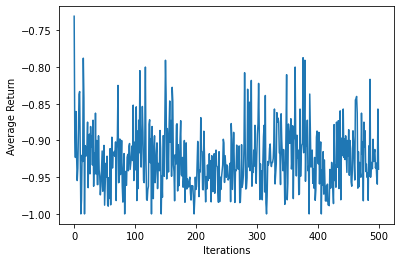

In [23]:
import matplotlib.pyplot as plt
plt.plot(return_data)
plt.xlabel("Iterations")
plt.ylabel("Average Return")